### GLM-eb 
@author: Jordan, Ben

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import scipy as sp
from scipy import io as sio
import statistics
import mat73
import glmmod

### load dataset (choose a. or b.):

#### a. sample data

In [2]:
# load & format sample data
filepath = 'sampleData.mat'
mat = sio.loadmat(filepath)
ST = mat['ST']
P = mat['P']
hd = mat['hd']*(np.pi/180) # [0,2pi] rad

#### b. blackstad data

In [3]:
# # load blackstad data
# filepath = 'C:\\Users\\17145\\OneDrive - NTNU\\Documents\\methods-project\\data_code\\curatedUnitsJS\\passuPython.mat'
# filepath_pos = 'C:\\Users\\17145\\OneDrive - NTNU\\Documents\\methods-project\\data_code\\curatedUnitsJS\\P.mat'
# mat = scipy.io.loadmat(filepath)

# mat_pos = mat73.loadmat(filepath_pos)

### viz parameters

In [4]:
plt.rcParams['figure.figsize'] = (4,2)
plt.rc('axes', labelsize=10); plt.rc('axes', titlesize=10)
plt.style.use('ggplot'); plt.rc('font', size=10);

### run models

1. set everything up

In [5]:
numUnits = 1
llh_err_units = {}
best_model_units = {}
u = 1

print('unit ' + str(u))
RP = [75, 75]
t_raw = P[:,0]; dt = t_raw[1]-t_raw[0];

# initialize class instance
g = glmmod.glm(ST,P,hd)

# prepare the data
posgrid_raw,_ = g.pos_map(nbins=10)
ebgrid_raw,_ = g.eb_map(nbins=10, rp=RP) # here we assume the reference point
hdgrid_raw,_ = g.eb_map(nbins=10, rp=RP) # here we assume the reference point
smooth_fr, raw_spktrn, filt, dt = g.conv_spktrain() # get spiketrain (raw = convolved)
posgrid,ebgrid,hdgrid,spiketrain = g.speed_threshold(posgrid_raw,ebgrid_raw,hdgrid_raw,raw_spktrn)

# dictionaries with info about each model
stateDict = {
    0: [posgrid,ebgrid],
    1: posgrid,
    2: ebgrid,
    3: hdgrid,
    4: [posgrid,hdgrid]
}

labelDict = {
    0: 'PE',
    1: 'P',
    2: 'E',
    3: 'H',
    4: 'PH'
}

allModels = {}
numModels = 5

# get test/train indices (same for each model)
kfoldIdx, kfoldIdx_df = g.kfoldSplit(spiketrain, nfolds=10)

unit 1


2. iterate through all models of interest (CONDENSED VERSION)

In [6]:
for model in range(numModels):

    mt = labelDict[model]
    print('processing model ' + str(model) + ' (' + mt + ') ...')

    # get state matrix
    stateIn = stateDict[model]
    statemat, expr = g.squish_statemat(spiketrain, stateIn, modelType=mt)

    # optimize model parameters
    kres, train_y, test_y, train_x, test_x, data, param = g.kfoldOptim(kfoldIdx_df,statemat,modelType=mt)

    # check the model fit
    testfit = g.get_testFit(mt,kres,train_y,test_y,train_x,test_x)

    # package outputs
    modelPackage = g.packageOutput(kfoldIdx_df,kres,train_y,train_x,test_y,test_x,testfit) # FIX

    # save in allModels dictionary
    allModels[model] = modelPackage

processing model 0 (PE) ...


c:\Users\jordannc\OneDrive - NTNU\Documents\github_local\Python\simulationsProject\GLM\glmmod.py:442: RuntimeWarning: overflow encountered in exp
  y_hat = np.exp(x @ param[1:] + param[0])
c:\Users\jordannc\OneDrive - NTNU\Documents\github_local\Python\simulationsProject\GLM\glmmod.py:445: RuntimeWarning: invalid value encountered in matmul
  dw = (x.T @ (y_hat - y)) / M
c:\Users\jordannc\OneDrive - NTNU\Documents\github_local\Python\simulationsProject\GLM\glmmod.py:442: RuntimeWarning: overflow encountered in exp
  y_hat = np.exp(x @ param[1:] + param[0])
c:\Users\jordannc\OneDrive - NTNU\Documents\github_local\Python\simulationsProject\GLM\glmmod.py:445: RuntimeWarning: invalid value encountered in matmul
  dw = (x.T @ (y_hat - y)) / M
c:\Users\jordannc\OneDrive - NTNU\Documents\github_local\Python\simulationsProject\GLM\glmmod.py:442: RuntimeWarning: overflow encountered in exp
  y_hat = np.exp(x @ param[1:] + param[0])
c:\Users\jordannc\OneDrive - NTNU\Documents\github_local\Python

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [83]:
fold = 1
bestp = kres[1].x/1e12 # best parameters
n = test_y[fold]
arrFactorial = np.vectorize(math.factorial) # array-wise factorial fn
meanFR_test = np.nanmean(n)

yhat_raw = g.get_rate(test_x[fold],bestp[1:],bestp[0]) # not normalized
yhat, _, _, _ = g.conv_spktrain(defaultST=False,spikeIn=yhat_raw) # normalized by dt (hz)
y_test_smooth, _, _, _ =  g.conv_spktrain(defaultST=False,spikeIn=train_y[fold]) 


# format the state matrix
b = np.ones((len(test_x[fold]),len(bestp)))
b[:,1:] = test_x[fold]

r = yhat_raw


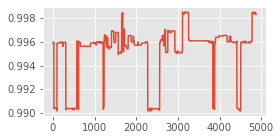

In [84]:
plt.plot(r)
# plt.plot(y_test_smooth)

3. perform model selection

In [ ]:
# model selection
llh, bestModel = g.modelSelection(allModels,labelDict)

In [ ]:
# display results
llh_err = g.plot_llh(allModels,labelDict)